## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.spatial import distance_matrix
import networkx as nx
import cv2
import json
import os

# Utils for vector field processing
def generate_vector_field_map(node_coords, height, width):
    # A function that generates the vector field based on node coordinates
    vector_field = np.zeros((height, width, 2))  
    for i in range(len(node_coords) - 1):
        start = node_coords[i]
        end = node_coords[i + 1]
        cv2.line(vector_field, tuple(start), tuple(end), (1, 1), 2)  # simplified example
    return vector_field

def compute_resistivity(node_a, node_b, vector_field):
    vector = node_b - node_a
    alignment = np.dot(vector, vector_field[node_a[1], node_a[0]]) / np.linalg.norm(vector)
    distance = np.linalg.norm(vector)
    return (1 - alignment) * distance

# Utils for data processing
def load_annotation(json_file):
    """Load JSON annotation for a vine image."""
    with open(json_file, 'r') as f:
        annotation = json.load(f)
    return annotation

def parse_features(annotation):
    """Extract vine features (nodes and branch labels) from the annotation JSON."""
    # Access the 'VineImage' list, and then the 'VineFeature' inside it
    vine_images = annotation.get('VineImage', None)
    
    if vine_images is None or len(vine_images) == 0:
        raise KeyError("'VineImage' key not found or empty in the JSON file. Check the JSON structure.")
    
    # Assuming we are dealing with the first image in the list
    features = vine_images[0].get('VineFeature', None)
    
    if features is None:
        raise KeyError("'VineFeature' key not found in the JSON file under 'VineImage'. Check the JSON structure.")
    
    nodes = []
    branches = []
    
    # The `VineFeature` is a list of lists, so we need to iterate over each inner list
    for feature_list in features:
        for feature in feature_list:
            # Check for 'FeatureType' and other keys
            if 'FeatureType' in feature:
                if feature['FeatureType'] in ['rootCrown', 'branchNode', 'growingTip', 'pruningCut']:
                    nodes.append({
                        'id': feature['FeatureID'],
                        'coordinates': feature['FeatureCoordinates'],
                        'type': feature['FeatureType']
                    })
            if 'ParentID' in feature:
                branches.append({
                    'parent_id': feature['ParentID'],
                    'child_id': feature['FeatureID'],
                    'branch_label': feature.get('BranchLabel', 'unknown')  # Use default if BranchLabel is missing
                })
    
    return nodes, branches


def generate_heatmaps(nodes, image_width, image_height):
    """Generate Gaussian heatmaps for node positions."""
    heatmaps = np.zeros((len(nodes), image_height, image_width), dtype=np.float32)
    for i, node in enumerate(nodes):
        coord = node['coordinates']
        x, y = coord
        heatmap = np.zeros((image_height, image_width))
        heatmap[x, y] = 1
        heatmap = gaussian_filter(heatmap, sigma=2)
        heatmaps[i] = heatmap
    return heatmaps


class VineDataset(Dataset):
    """Custom dataset for vine images and annotations stored in the same folder."""
    def __init__(self, data_dir, height=256, width=256):
        self.data_dir = data_dir
        self.height = height
        self.width = width
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_file)
        annotation_path = os.path.join(self.data_dir, img_file.replace('.jpg', '_annotation.json'))

        # Load and resize image
        image = cv2.imread(img_path)
        image = cv2.resize(image, (self.width, self.height))

        # Load and parse annotation
        annotation = load_annotation(annotation_path)
        nodes, branches = parse_features(annotation)

        # Generate heatmaps for nodes
        heatmaps = generate_heatmaps(nodes, self.height, self.width)

        # Convert to PyTorch tensors
        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        heatmaps = torch.from_numpy(heatmaps).float()

        return image, heatmaps

## Stacked Hourglass Network

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class HourglassBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(HourglassBlock, self).__init__()
        self.downsample = nn.MaxPool2d(2, stride=2)
        self.residual = ResidualBlock(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        down = self.downsample(x)
        down = self.residual(down)
        up = self.upsample(down)
        return up + x

class StackedHourglassNetwork(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(StackedHourglassNetwork, self).__init__()
        self.hg1 = HourglassBlock(in_channels, out_channels)
        self.hg2 = HourglassBlock(out_channels, out_channels)
        self.final_layer = nn.Conv2d(out_channels, 1, kernel_size=1)  # output heatmap

    def forward(self, x):
        x = self.hg1(x)
        x = self.hg2(x)
        x = self.final_layer(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate the model
model = StackedHourglassNetwork(3, 256).to(device)


## Tree Reconstruction with Graph Optimization

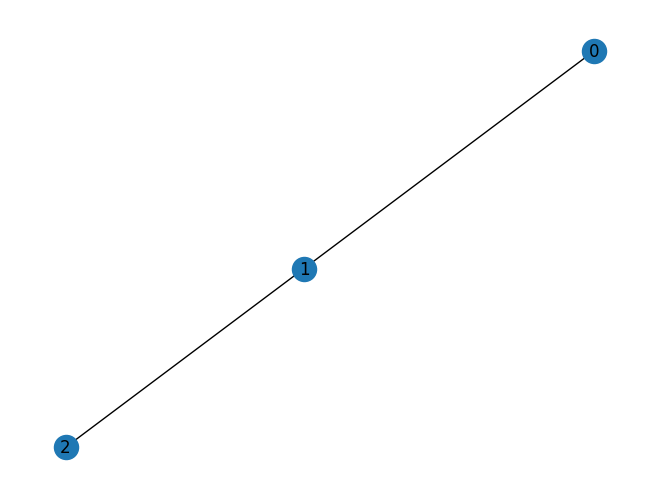

In [3]:
def build_resistivity_graph(node_coords, vector_field):
    G = nx.Graph()
    for i, node_a in enumerate(node_coords):
        for j, node_b in enumerate(node_coords):
            if i != j:
                resistivity = compute_resistivity(node_a, node_b, vector_field)
                G.add_edge(i, j, weight=resistivity)
    return G

def reconstruct_tree(node_coords, vector_field):
    G = build_resistivity_graph(node_coords, vector_field)
    # Use shortest path to reconstruct tree structure
    mst = nx.minimum_spanning_tree(G)
    return mst

# Example usage
node_coords = np.array([[100, 200], [150, 220], [200, 300]])  # dummy node coordinates
vector_field = generate_vector_field_map(node_coords, 512,512)
tree_structure = reconstruct_tree(node_coords, vector_field)

# Visualize the tree structure
import matplotlib.pyplot as plt
nx.draw(tree_structure, with_labels=True)
plt.show()


## Training and Optimization

In [4]:
# Define dataset and dataloader
train_dataset = VineDataset(data_dir='./3D2cut_Single_Guyot/01-TrainAndValidationSet', height=3024, width=4032) # TODO: split into train and validation
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Loss function and optimizer
criterion = nn.MSELoss()  # Loss for heatmap predictions
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    for images, heatmaps in train_loader:
        images, heatmaps = images.to(device), heatmaps.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, heatmaps)
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch}, Loss: {loss.item()}')

MemoryError: Unable to allocate 5.09 GiB for an array with shape (112, 4032, 3024) and data type float32